# Fuzzy C-means Clustering with MNIST
This notebook investigates using fuzzy c-means clustering (FCM) on the original feature space of the MNIST dataset. FCM is the algorithm that will be used initialize the membership function parameters for a neuro-fuzzy classifier.

In [1]:
import gzip
import numpy as np

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("mnist/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("mnist/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("mnist/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("mnist/t10k-labels-idx1-ubyte.gz", [10000])

# convert to floats
train_images = train_images.astype(np.float) / 255
test_images = test_images.astype(np.float) / 255

The data is loaded into memory as NumPy arrays and the image data is converted to floats and scaled between 0 and 1.

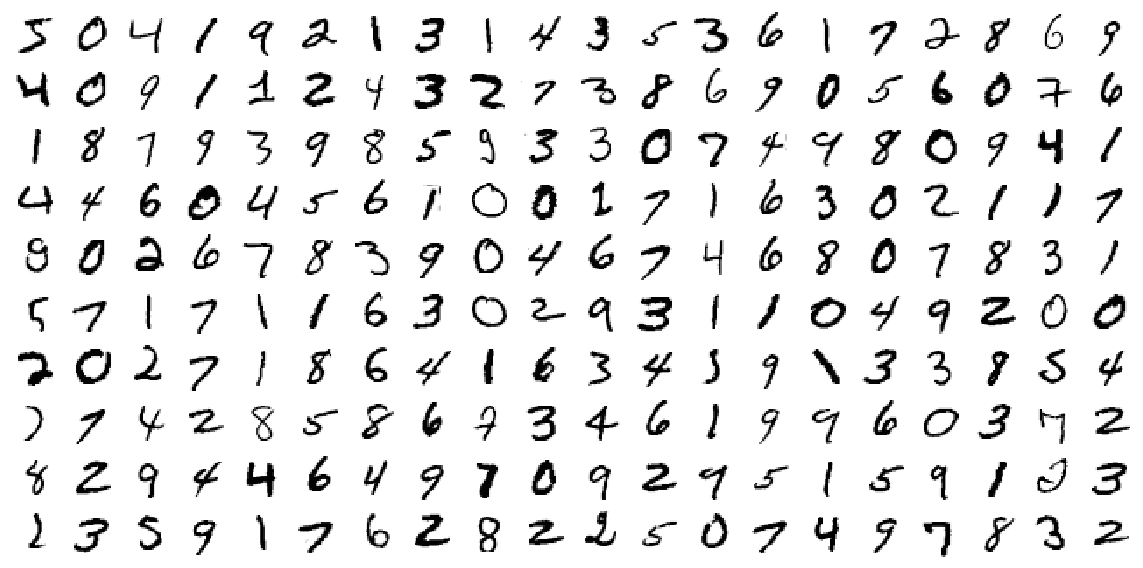

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax_array = plt.subplots(10, 20, figsize=(16, 8))
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(train_images[i,:,:], cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Some sample images are plotted above to ensure that the data has been loaded correctly.

## Visualizing the Clusters
Clustering algorithms typically perform poorly in high dimensional spaces. Extra care needs to be taken to ensure that the clusters fit the data correctly. A common problem with FCM (in high dimensions) is that all the clusters aggregate near the center of mass of the dataset.

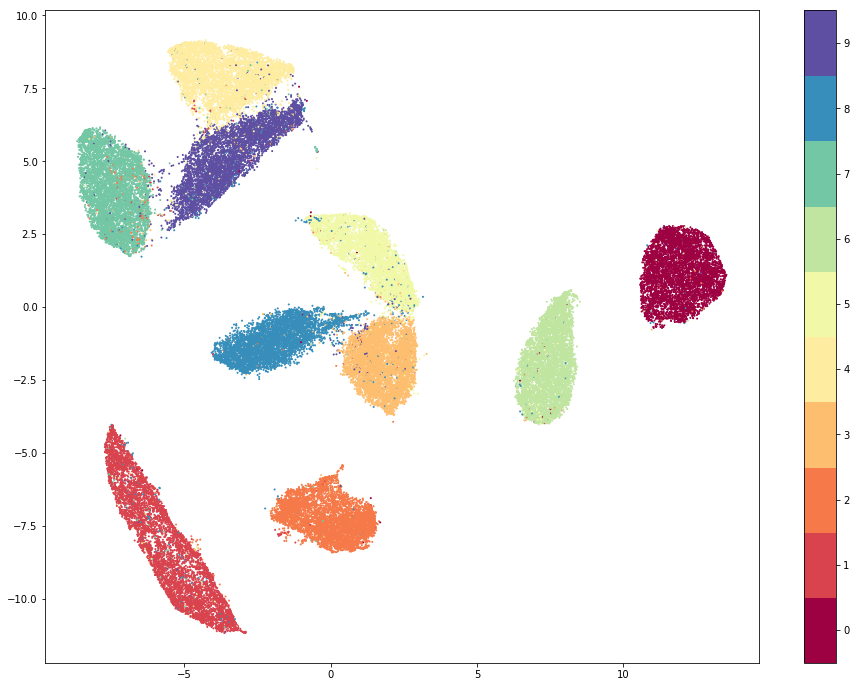

In [3]:
import os
import pickle
from umap import UMAP

_cache_dir = "cache/umap.pickle"
_ignore_cache = False

# reshape the training images into vectors
data = train_images.reshape(60000, 28 * 28)

# create mapping and cache the file
if not os.path.isfile(_cache_dir) or _ignore_cache:
    reducer = UMAP(random_state=42).fit(data)
    pickle.dump(reducer, open(_cache_dir, "wb"))
# load file from cache
else:
    reducer = pickle.load(open(_cache_dir, "rb"))

# transform the data to 2d
embedded = reducer.transform(data)

# centroid of the entire dataset
centroid = reducer.transform(np.mean(data, axis=0, keepdims=True)).squeeze()

# plot the data
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

In order to visualize the data in 2 dimensions, a UMAP embedding is created. Shown above is the dataset mapped to 2D.

## Clustering
Using the UMAP mapping, the best fuzzifier parameter (m) will be found for the dataset. The closer m is to one, the better the clustering will perform, but the more it will behave like hard clustering.

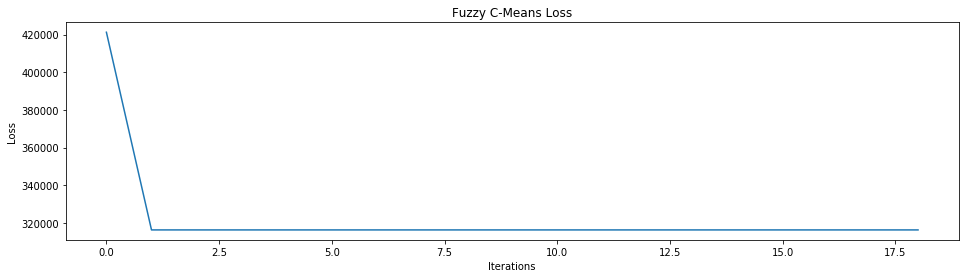

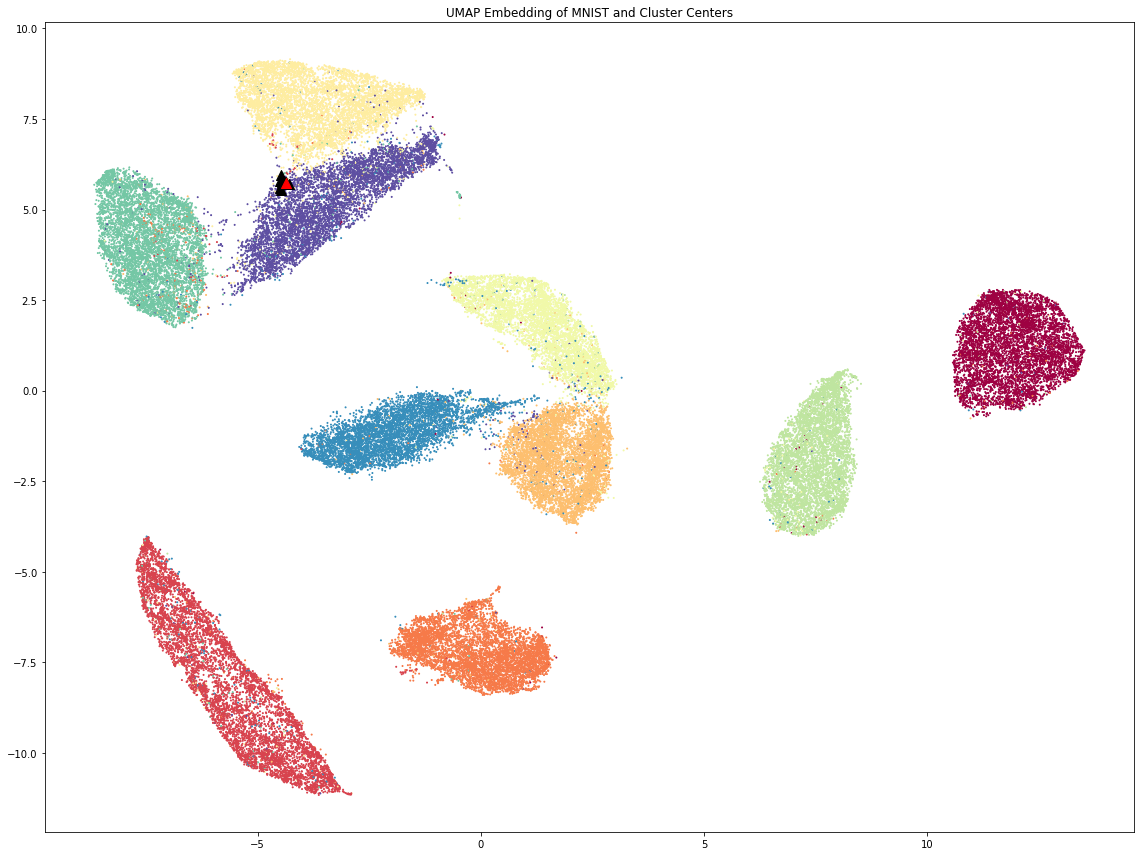

In [4]:
import skfuzzy as skf


def evaluate_clustering(data, c, m, error=1e-8, maxiter=1000, init=None, seed=0):
    # apply fuzzy clustering
    centers, memberships, u0, d, jm, p, fpc = skf.cmeans(
        data, c, m, error, maxiter, init=init, seed=seed)

    # plot the loss
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(p), jm)
    plt.title("Fuzzy C-Means Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    # plot data with centers
    plt.figure(figsize=(16, 12))
    plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')
    plt.title("UMAP Embedding of MNIST and Cluster Centers")

    # plot centers of fuzzy clusters
    embedded_centers = reducer.transform(centers)
    plt.scatter(embedded_centers[:,0], embedded_centers[:,1], s=100, c="k", marker="^")
    plt.scatter(centroid[0], centroid[1], s=100, c="r", marker="^")
    
    # format the plots
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    
    
evaluate_clustering(data.T, 10, 2.0)

All of the clusters (black triangles) have moved to the center of mass of the entire dataset (red triangle).

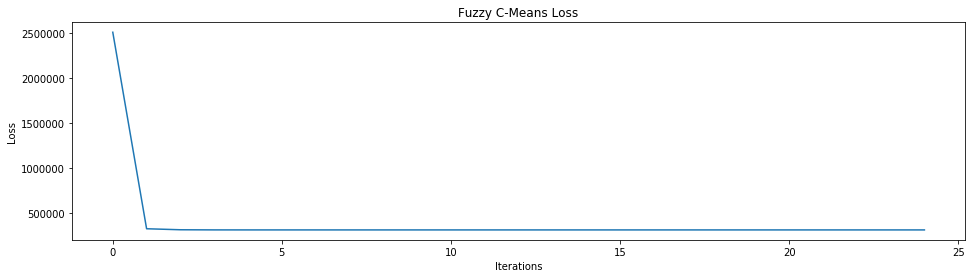

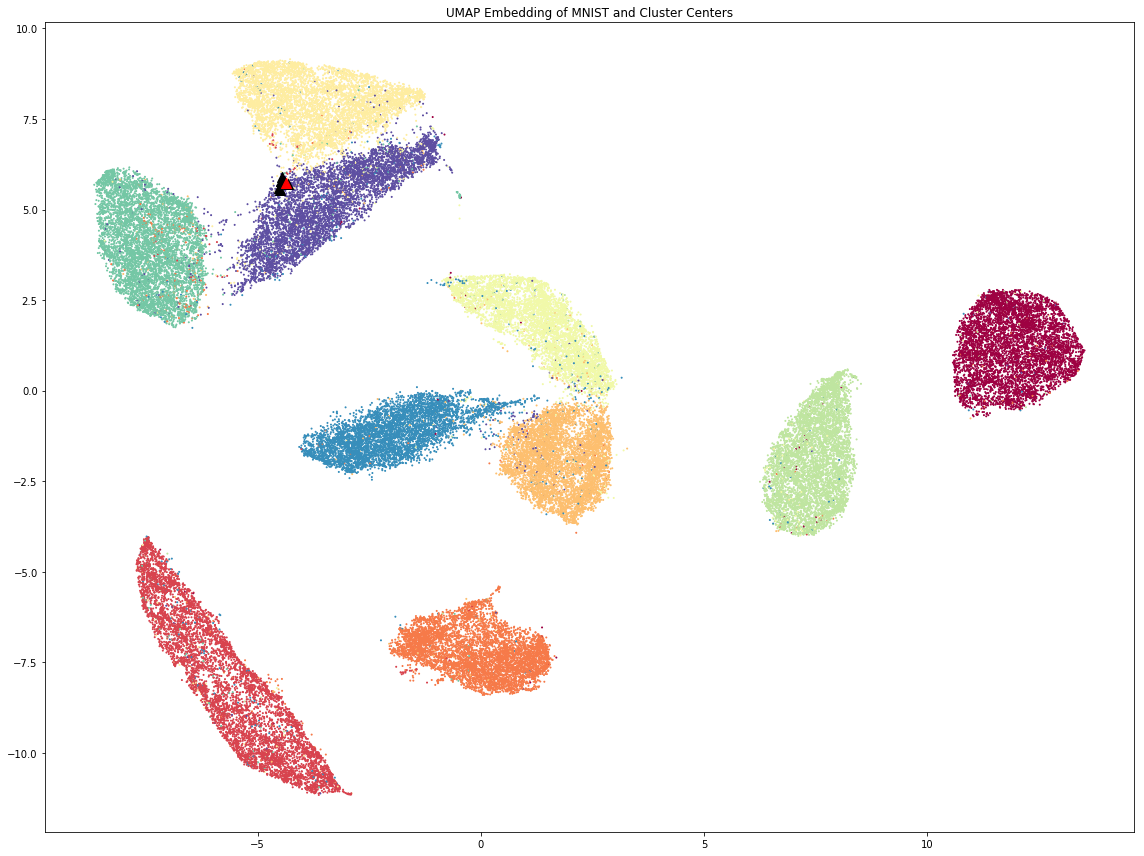

In [5]:
init_memberships = np.zeros((10, 60000))
init_memberships[train_labels,np.arange(60000)] = 1

evaluate_clustering(data.T, 10, 2.0, init=init_memberships)

Initializing the dataset differently has no effect on the final outcome. All of the centers settle at the local minima near the center of mass.

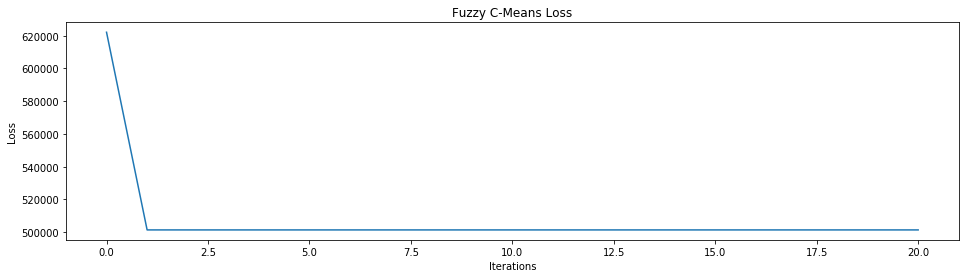

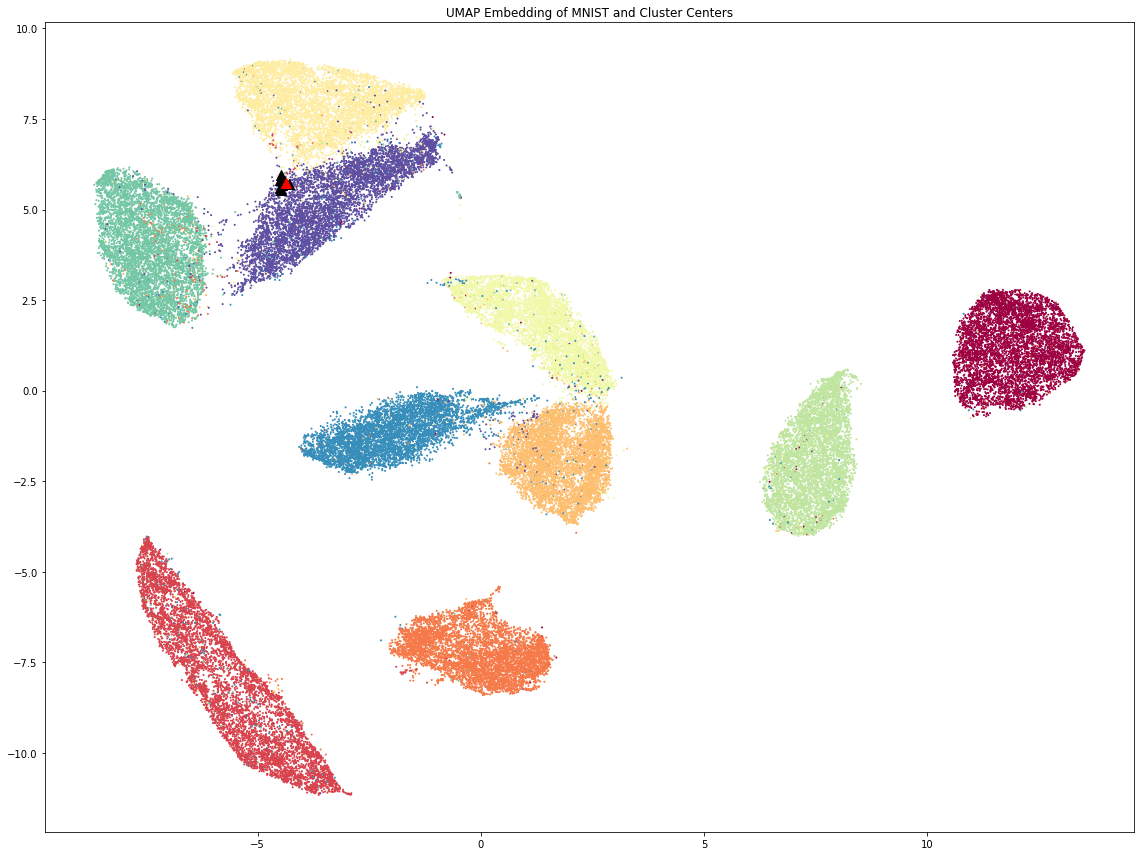

In [6]:
evaluate_clustering(data.T, 10, 1.8)

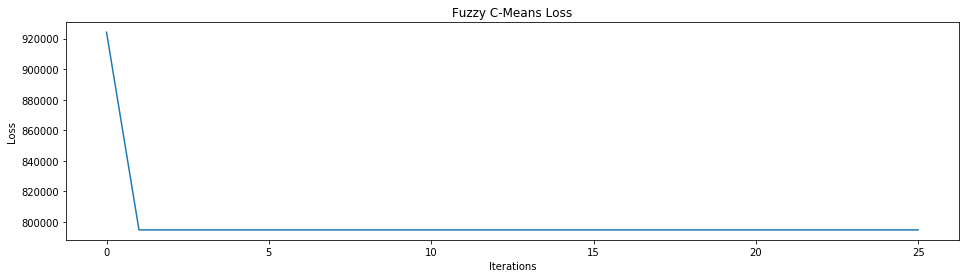

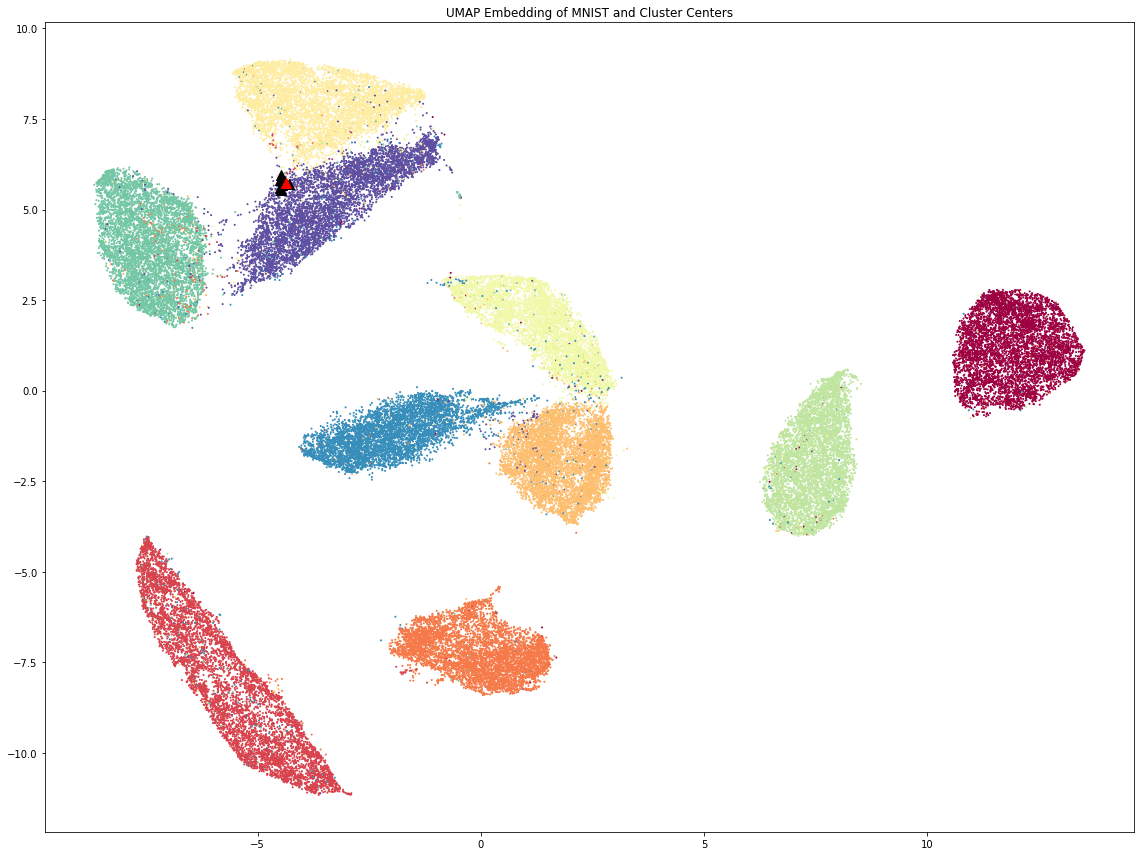

In [7]:
evaluate_clustering(data.T, 10, 1.6)

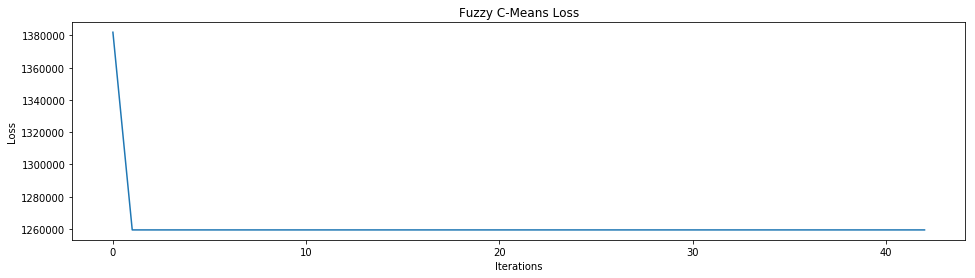

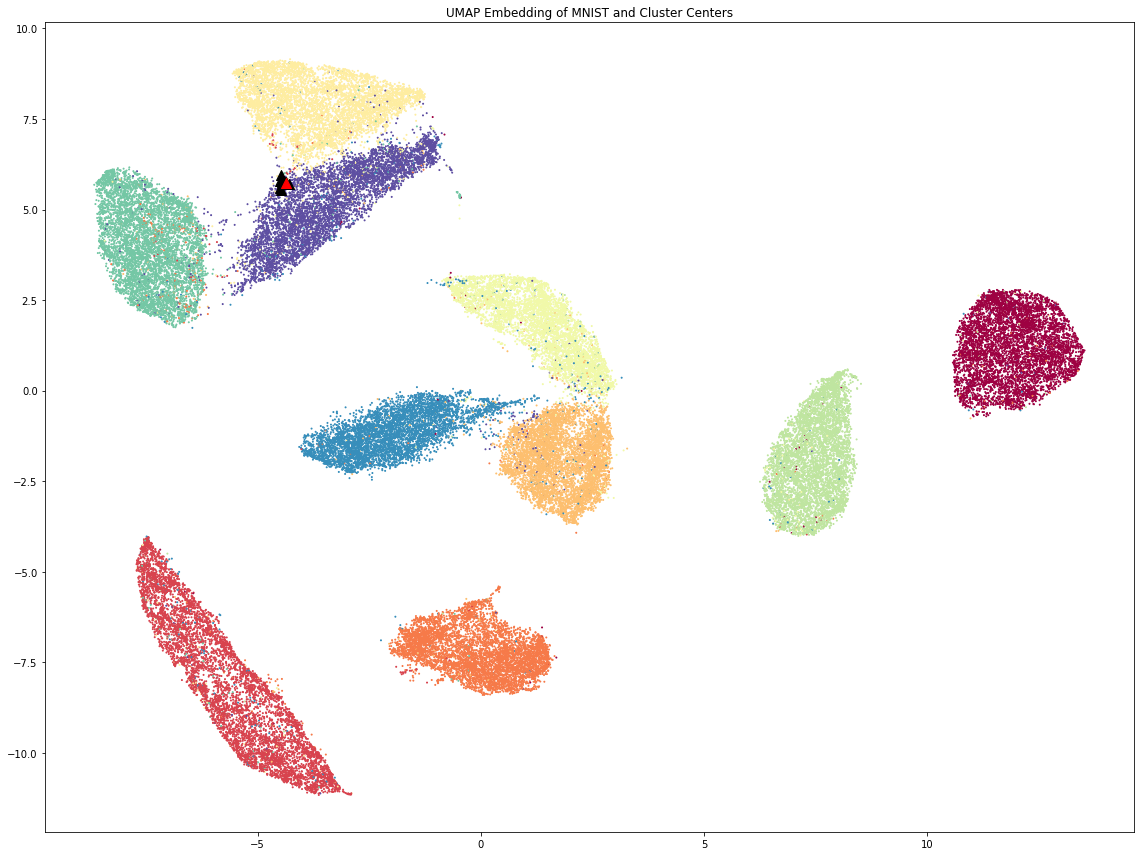

In [8]:
evaluate_clustering(data.T, 10, 1.4)

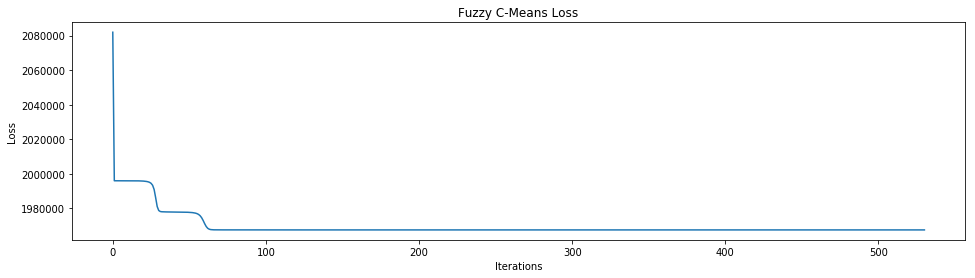

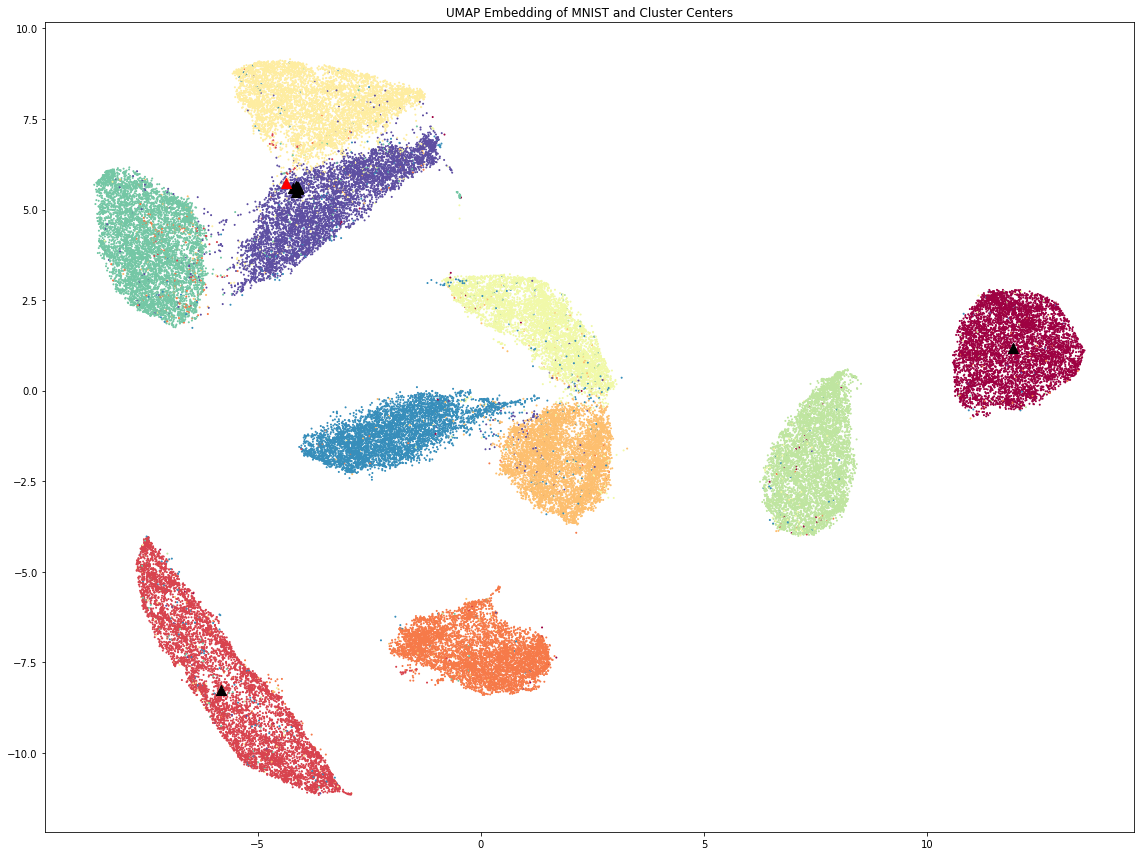

In [9]:
evaluate_clustering(data.T, 10, 1.2)

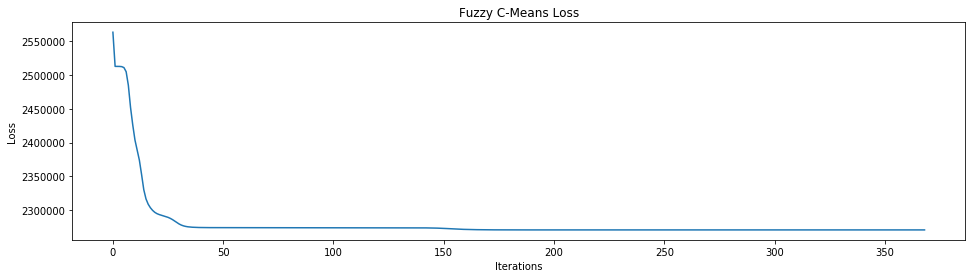

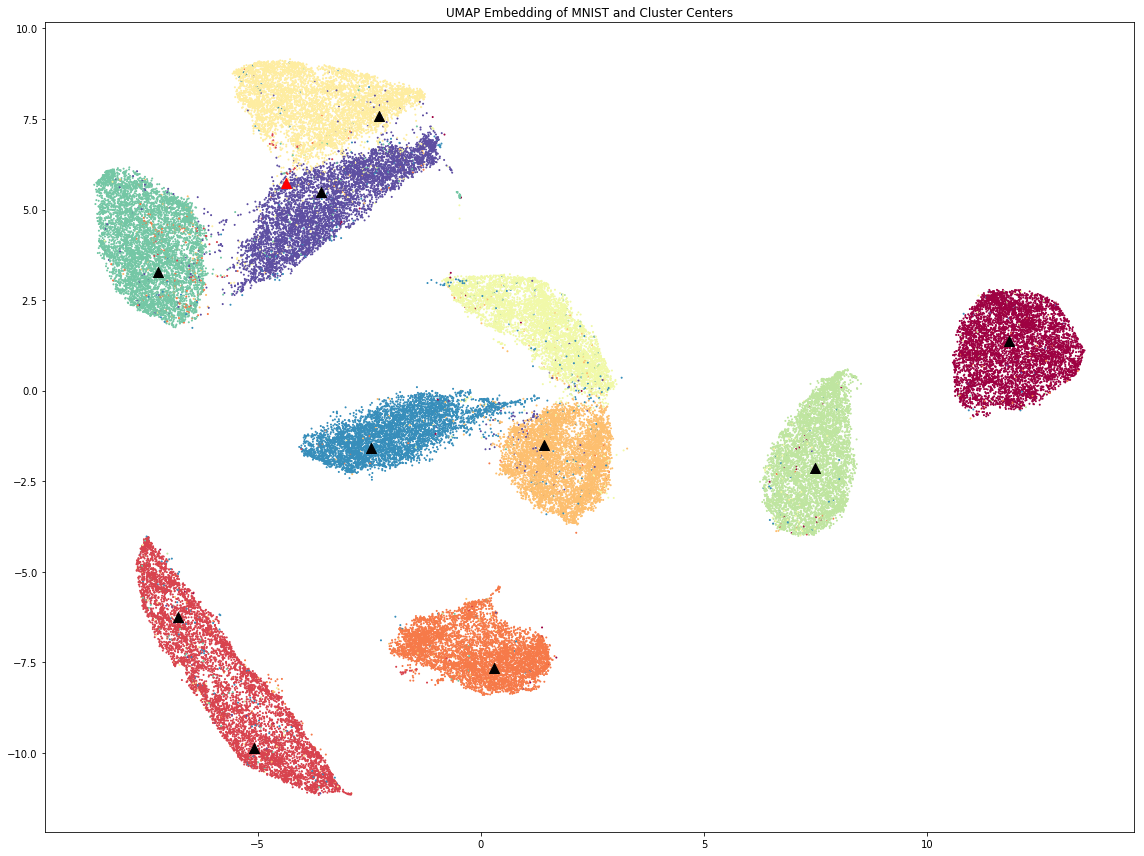

In [10]:
evaluate_clustering(data.T, 10, 1.1)

The value of m = 1.1 is the first value that gives good clustering results. Nine of the ten clustering are correclty given a center.

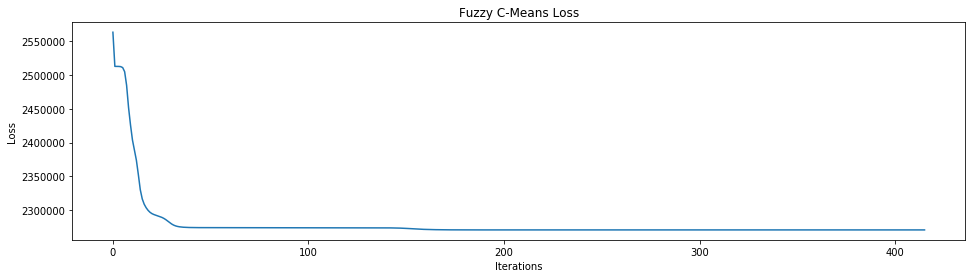

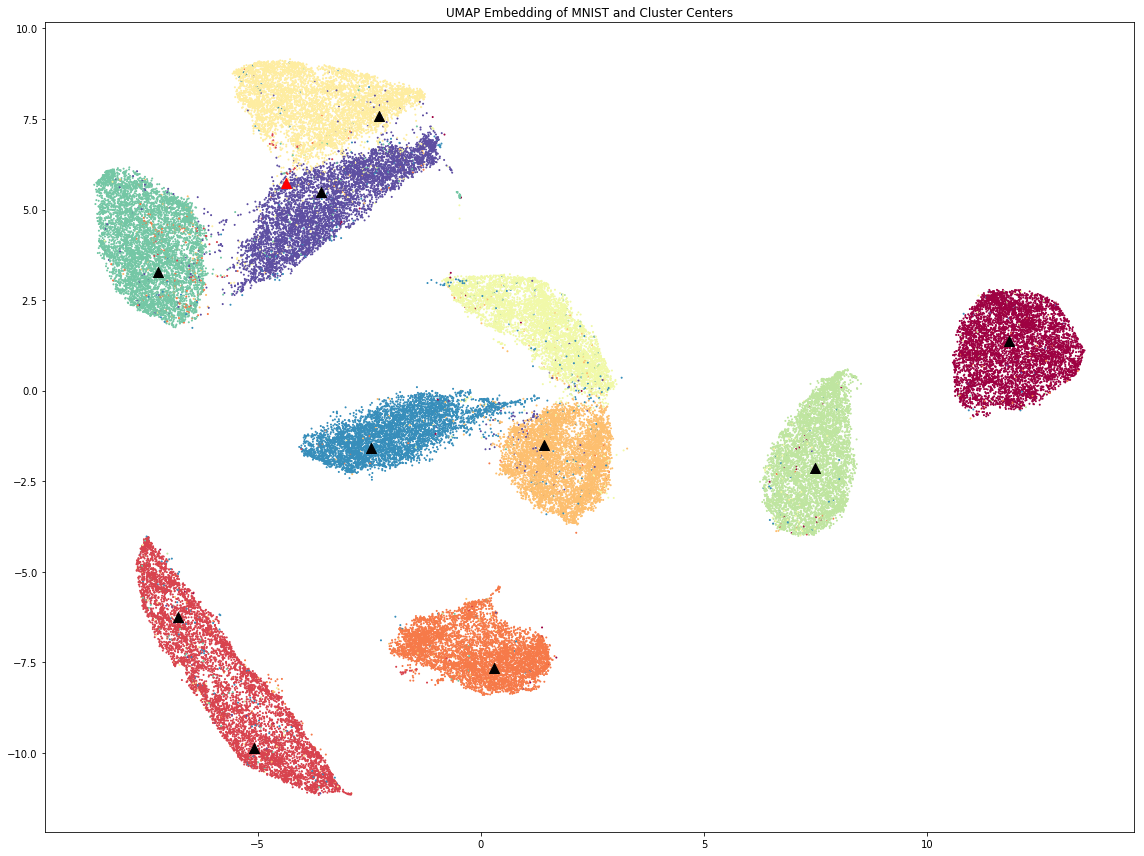

In [11]:
evaluate_clustering(data.T, 10, 1.1, error=1e-10, maxiter=10000)

Allowing the algorithm run for longer does not seem to improve the results of the algorithm.

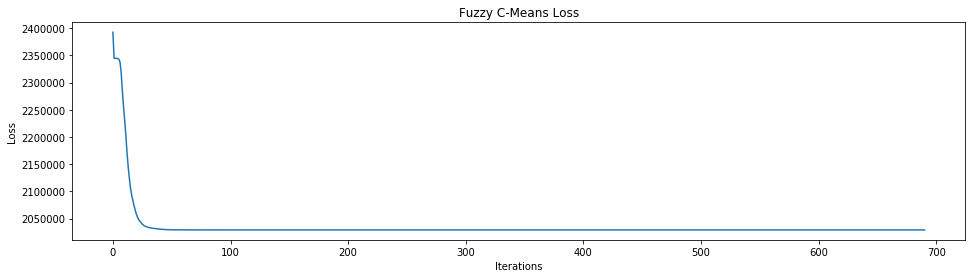

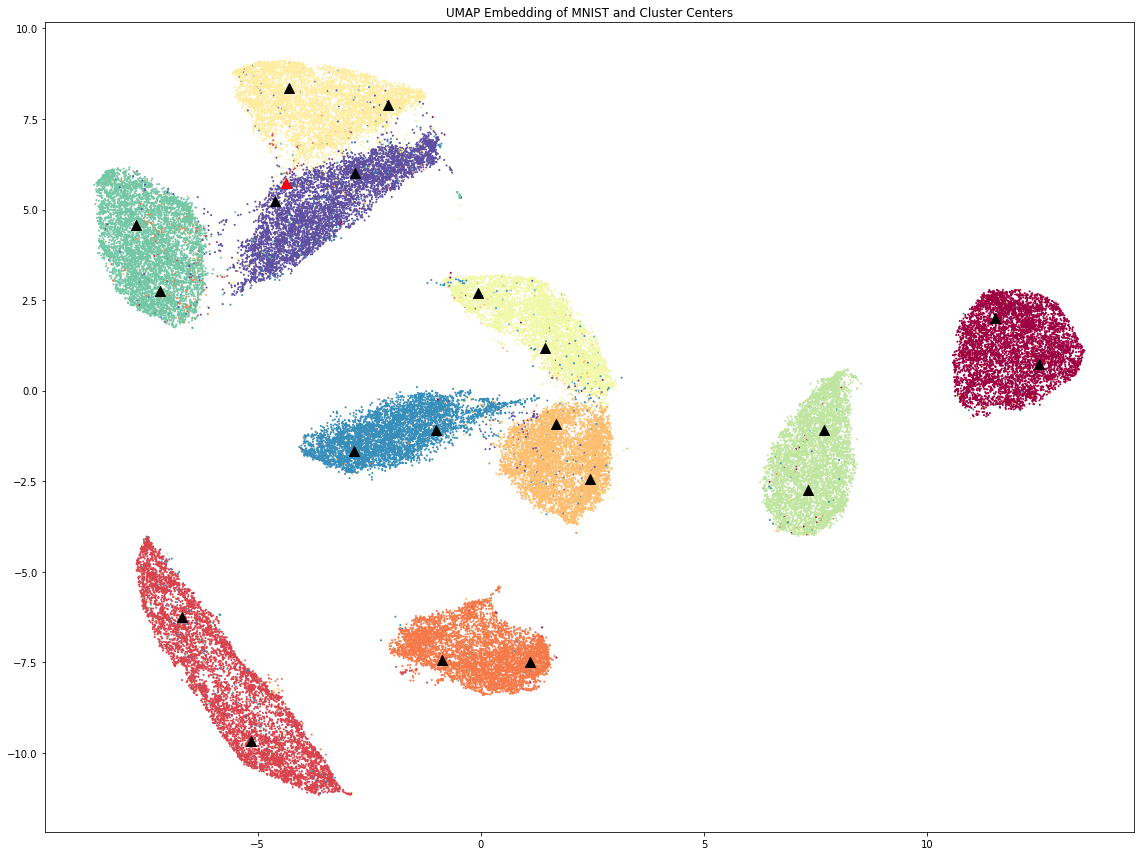

In [12]:
evaluate_clustering(data.T, 20, 1.1, maxiter=1000)

With 20 clusters the algorithm seems to distribute the clusters better throughout the data.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2144141b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f214415a240>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f21441419e8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f214415a8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f214415ac18>],
 'means': []}

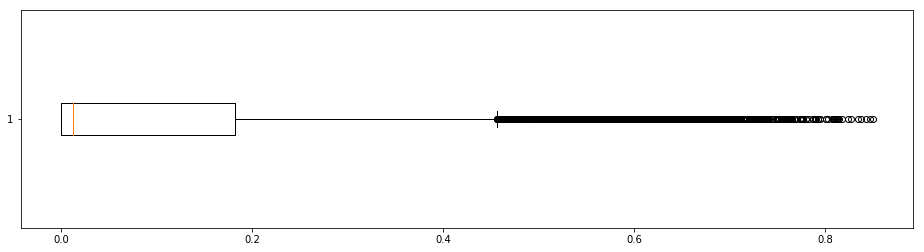

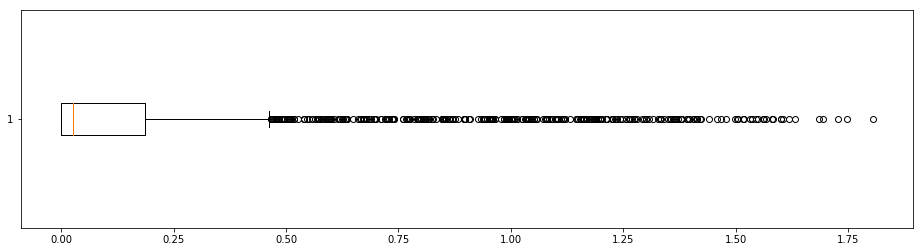

In [13]:
centers, memberships, u0, d, jm, p, fpc = skf.cmeans(data.T, 10, 1.1, 1e-8, 1000, seed=0)

def compute_sigma(data, memberships, centers):
    # remove any points with a membership of one
    mask = np.any(memberships >= 1.0, axis=0)
    data = data[:,~mask]
    memberships = memberships[:,~mask]
    
    data = np.expand_dims(data, axis=0)
    memberships = np.expand_dims(memberships, axis=1)
    centers = np.expand_dims(centers, axis=2)
    
    return np.mean(np.sqrt(-np.square(data - centers) / (2 * np.log(memberships))), axis=2)

# calculated sigmas
init_sigma = compute_sigma(data.T, memberships, centers)

plt.figure(figsize=(16, 4))
plt.boxplot(centers.reshape(-1), vert=False)

plt.figure(figsize=(16, 4))
plt.boxplot(init_sigma.reshape(-1), vert=False)

The values for mu and sigma seem reasonable. The method for computing the sigmas are the same methods used by the genfis method in MATLAB. These parameters will be tried in a neural network in another notebook.